In [84]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing # библиотека для проведения нормализации
# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
# устанавливаем библиотеку
# !pip install nltk

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [85]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [33]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > requirements.txt

In [86]:

# Подгрузим наши данные из соревнования

# DATA_DIR = '/kaggle/input/sf-booking/'
# df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
# df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
# sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

DATA_DIR = 'data'
df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн


In [87]:

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

# sample data для трейна
df_train = df_train.sample(frac = 0.1, replace = False, random_state=42)

# такое название пока для того, чтобы не переписывать переменные в дальнейшем коде
sample_data = pd.concat([df_test, df_train], axis=0, ignore_index=True)
# sample_data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


## <center> Анализ текста отзывов

Данный раздел сделан в основном по рекомендациям Сергея Добдина.

### <center> [Sample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) данные

Насколько я понял, данный код, позволяет выбрать из тренировочного датасета, определенное количество рандомных строк, чтобы обучать модель на них, тем самым не нагружая компьютер большим количеством информации.

In [36]:
# sample_data = data.sample(frac = 0.1, replace = False, random_state=42)
# print(f'Далее рассматриваем датасет, с количеством строк: {sample_data.shape[0]}')

### <center> Работа с отзывами

Объединить положительные и отрицательные отзывы. Дальнейшую работу производим с данным признаком.

In [37]:

# объединяем положительные и отрицательные отзывы
sample_data['review'] = sample_data['negative_review'] + sample_data['positive_review']

# создаём метку для плохого отзыва (1 - True, 0 - False)
sample_data["is_bad_review"] = sample_data["reviewer_score"].apply(lambda x: 1 if x < 5 else 0)

# выбираем только релевантные столбцы для работы над отзывами
reviews_df = sample_data.loc[:, ["review", "is_bad_review", "reviewer_score", "sample"]]
reviews_df.head()


,review,is_bad_review,reviewer_score,sample
0,Would have appreciated a shop in the hotel th...,1,0.0,0
1,No tissue paper box was present at the roomNo...,1,0.0,0
2,Pillows Nice welcoming and service,1,0.0,0
3,No Negative Everything including the nice upgr...,1,0.0,0
4,No Negative Lovely hotel v welcoming staff,1,0.0,0


### <center> Очистка данных

In [38]:
# удалим 'No Negative' или 'No Positive' из текста
reviews_df["review"] = reviews_df[["review"]].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In [39]:
# https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/
# использование wordnet для анализа частей речи

import nltk
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer


def clean_text(text):
    # приводим к нижнему регистру
    text = text.lower()
    # разделение текста на слова и удаление знаков препинания 
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # удаляем цифры из текста
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # удаляем стоп-слова
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # удаляем пустые токены
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # лемматизация текста
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # удаляем слова из одной буквы
    text = [t for t in text if len(t) > 1]
    # объединяем текст
    text = " ".join(text)
    return(text)

# очистка текстовых данных
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dolzh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dolzh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dolzh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Т.к выполнение кода выше занимает до 6 минут сохраняем в csv.

In [40]:
# reviews_df.to_csv('reviews.csv', index=False)

In [44]:
# reviews_df = pd.read_csv('data/reviews.csv')

### <center> Создание новых признаков

In [45]:
# https://habr.com/ru/company/Voximplant/blog/446738/
# анализ тональности (настроения) текста отзыва

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dolzh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


второе промежуточное сохранение

In [46]:
# reviews_df.to_csv('data/reviews_2.csv', index=False)

In [47]:
# reviews_df = pd.read_csv('data/reviews_2.csv')

In [48]:
# создадим признак кол-во символов в отзыве
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# создадим признак кол-во слов в отзыве
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [55]:
reviews_df['review_clean'] = reviews_df['review_clean'].astype('str')

In [56]:
# https://habr.com/ru/post/585838/
# векторизация слов с помощью doc2vec и создание нового признака

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# получим список из taggedDocument, которые являются кортежами из
# списка слов0 в отзыве и тега, соответсвующего порядковому номеру отзыва
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# обучение модели Doc2Vec с помощью текстовых данных
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# преобразуем каждый документ в вектор данных
doc2vec_df = reviews_df["review_clean"].astype('str').apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

третье промежуточное сохранение

In [88]:
# reviews_df.to_csv('data/reviews_3.csv', index=False)
reviews_df = pd.read_csv('data/reviews_3.csv')

In [89]:
reviews_df['review_clean'] = reviews_df['review_clean'].fillna(' ')

In [90]:
# создание признака tf-idfs (оценка важности слова в тексте)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).astype('int8').toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

C:\Users\dolzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [91]:
reviews_df.head()

,review,is_bad_review,reviewer_score,sample,review_clean,neg,neu,pos,compound,nb_chars,...,word_yuk,word_yum,word_yummy,word_zara,word_zero,word_ziggo,word_zip,word_zone,word_zoo,word_zuid
0,Would have appreciated a shop in the hotel th...,1,0.0,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,...,0,0,0,0,0,0,0,0,0,0
1,No tissue paper box was present at the roomNo...,1,0.0,0,tissue paper box present roomno positive,0.159,0.580,0.261,0.3400,55,...,0,0,0,0,0,0,0,0,0,0
2,Pillows Nice welcoming and service,1,0.0,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,...,0,0,0,0,0,0,0,0,0,0
3,No Negative Everything including the nice upgr...,1,0.0,0,negative everything include nice upgrade hotel...,0.149,0.529,0.322,0.7845,166,...,0,0,0,0,0,0,0,0,0,0
4,No Negative Lovely hotel v welcoming staff,1,0.0,0,negative lovely hotel welcome staff,0.404,0.137,0.459,0.2023,43,...,0,0,0,0,0,0,0,0,0,0


In [92]:
reviews_df.shape

(167615, 6918)

### <center> Исследовательский анализ данных

In [93]:
reviews_df["is_bad_review"].value_counts(normalize = True)

1    0.778946
0    0.221054
Name: is_bad_review, dtype: float64

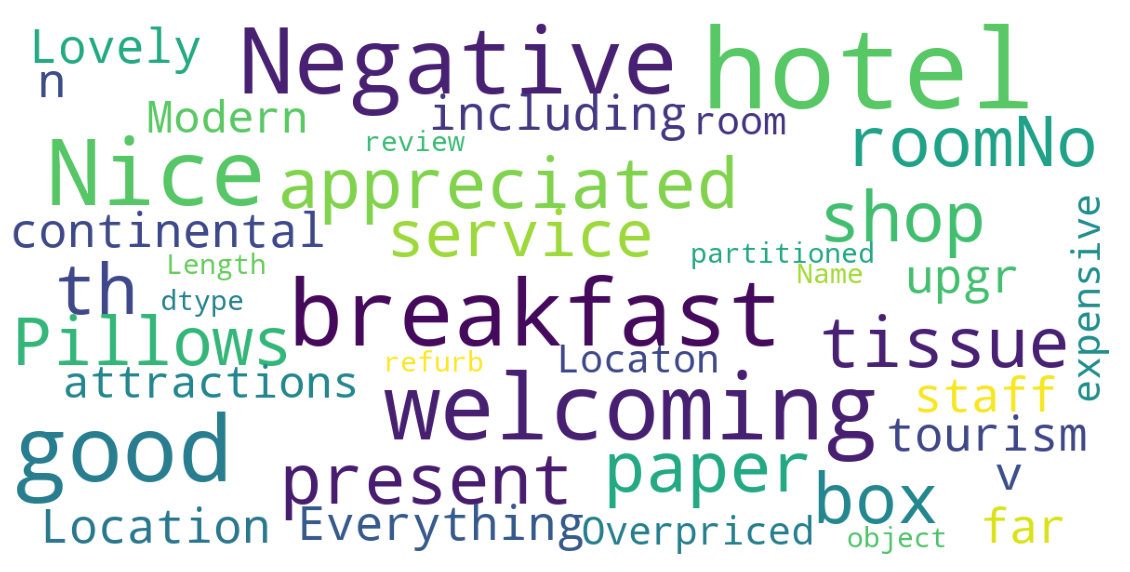

In [94]:
# использование wordcloud функции

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(reviews_df["review"])

In [95]:
# Топ позитивных отзывов (содержит > 5 слов)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
60512,Helpful friendly staffNo Positive,0.906
106539,i like friendly stuffNo Positive,0.903
53608,Smile More friendly I hope,0.902
55643,Cozy comfortable friendly,0.867
52312,I like evertgingNo Positive,0.859
148157,N a Friendly helpful staff,0.857
109168,All good Clean friendly polite relaxed,0.857
46483,friendly staff clean,0.855
109127,N A Super super super A class Hotel,0.854
136615,All good Great staff great location great value,0.854


In [96]:
# Топ негативных отзывов (содержит > 5 слов)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
129834,No Negative There s no downside,0.910
89443,No Negative I missed breakfast,0.890
79905,Nothing Classy calm perfect,0.880
107493,No Negative Noisy unpleasant staff poor room,0.873
74453,All No no no,0.868
95698,No Negative Everything s,0.855
165838,No Negative L emplacement,0.855
63390,No Negative Cold A C,0.855
143492,No Negative I m regular,0.855
124783,No Negative Extremely central No complaints,0.847


## <center> Создание новых признаков из оставшихся признаков

#### Из признака `hotel_address`

Из признака `hotel_address` получаем признак города

In [97]:
hotels_info = pd.DataFrame()
# функция выделения из адреса города
def adress_analysis(text):
    if text.split()[-1] == 'Kingdom':
        city = text.split()[-5]
        country = ' '.join(text.split()[-2:])
    else:
        city = text.split()[-2]
        country = text.split()[-1]
    return city

# создаем признак города
hotels_info['city'] = sample_data['hotel_address'].apply(adress_analysis)

In [98]:
hotels_info['city']

0             Milan
1         Amsterdam
2         Barcelona
3             Milan
4         Amsterdam
            ...    
167610        Paris
167611       London
167612    Amsterdam
167613    Amsterdam
167614    Amsterdam
Name: city, Length: 167615, dtype: object

Кодируем признак города

In [99]:

import category_encoders as ce # импорт для работы с кодировщиком
encoder = ce.OneHotEncoder(cols=['city']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels_info['city'])
hotels_info = pd.concat([hotels_info, type_bin], axis=1)

# удаляем исходный признак города
hotels_info = hotels_info.drop(columns=['city'])

C:\Users\dolzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [45]:
hotels_info.head(2)

,city_1,city_2,city_3,city_4,city_5,city_6
0,1,0,0,0,0,0
1,0,1,0,0,0,0


#### Из признака `reviewer_nationality`

Кодируем признак национальности ревьюэра оставившего отзыв

In [100]:

# убираем лишние пробелы из элементов признака
hotels_info['reviewer_nationality'] = sample_data['reviewer_nationality'].apply(lambda x: x.strip().lower())

# создаем список из 10 наиболее часто встречающихся национальностей
most_common_nations = hotels_info['reviewer_nationality'].value_counts(normalize=True)[:10].index.tolist()

# оставляем только национальности из списка, остальные Other
hotels_info['reviewer_nationality'] = hotels_info['reviewer_nationality'].apply(lambda x: x if x in most_common_nations else 'other')

# применяем однократное кодирование для признака (11 признаков)
import category_encoders as ce # импорт для работы с кодировщиком

encoder = ce.OneHotEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels_info['reviewer_nationality'])
hotels_info = pd.concat([hotels_info, type_bin], axis=1)

# удаляем признак национальности
hotels_info = hotels_info.drop(columns=['reviewer_nationality'])


C:\Users\dolzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [47]:
hotels_info.head(2)

,city_1,city_2,city_3,city_4,city_5,city_6,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,reviewer_nationality_8,reviewer_nationality_9,reviewer_nationality_10,reviewer_nationality_11
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


#### Из признака `tags`

In [101]:
# функция перевода текста тегов в список
def tags_to_list(text):
    tag_list = text[2:-2].split('\', \'')
    tag_list = [i.strip().lower() for i in tag_list]
    return tag_list

hotels_info['tags'] = sample_data['tags'].apply(tags_to_list)

In [102]:
hotels_info['tags'].head(2)

0    [leisure trip, couple, double room, stayed 2 n...
1    [leisure trip, group, triple room, stayed 1 ni...
Name: tags, dtype: object

Работа с наиболее часто встречающимися тегами

In [103]:
# создаём пустой список тегов
tags = []
# каждый новый встречающийся тег из каждой строки признака тегов добавляем в список
for tag_list in hotels_info['tags']:
    for tag in tag_list:
        tags.append(tag)
        
from collections import Counter
cnt = Counter(tags)

# Для тегов, встречающихся более 2000 раз, создаем отдельные признаки в новом датасете.
# Так же учитываем, что не рассматриваем теги, с количеством ночей. Из этих тегов получим количество ночей.
for i in cnt.most_common():
    if i[1] > 2000 and 'night' not in i[0]:
        feature = i[0]
        hotels_info[feature] = sample_data['tags'].apply(lambda x: 1 if feature in x else 0)

In [104]:
hotels_info.head(2)

,city_1,city_2,city_3,city_4,city_5,city_6,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,...,deluxe double room,double or twin room,standard double or twin room,classic double room,superior double or twin room,2 rooms,single room,standard twin room,twin room,executive double room
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
hotels_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167615 entries, 0 to 167614
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   city_1                          167615 non-null  int64 
 1   city_2                          167615 non-null  int64 
 2   city_3                          167615 non-null  int64 
 3   city_4                          167615 non-null  int64 
 4   city_5                          167615 non-null  int64 
 5   city_6                          167615 non-null  int64 
 6   reviewer_nationality_1          167615 non-null  int64 
 7   reviewer_nationality_2          167615 non-null  int64 
 8   reviewer_nationality_3          167615 non-null  int64 
 9   reviewer_nationality_4          167615 non-null  int64 
 10  reviewer_nationality_5          167615 non-null  int64 
 11  reviewer_nationality_6          167615 non-null  int64 
 12  reviewer_nationality_7        

Работа с тегами, содержащими подстроку `night`

In [106]:
def nights_in_hotel(tags_list):
    """
    Находит в списке тегов тег с количеством ночей.
    Из данного тега возвращается количество ночей.
    """
    for tag in tags_list:
        if 'night' in tag:
            for i in tag.split():
                if i.isdigit():
                    return i
    return np.NaN

# применяем функцию, получаем признак в строковом формате, внутри которого число (присутствуют пропуски)
hotels_info['nights_in_hotel'] = hotels_info['tags'].apply(nights_in_hotel)

# заполняем пропуски модой
hotels_info['nights_in_hotel'] = hotels_info['nights_in_hotel'].fillna(hotels_info['nights_in_hotel'].mode()[0])

# приводим к типу int
hotels_info['nights_in_hotel'] = hotels_info['nights_in_hotel'].astype('int')


In [107]:
hotels_info['nights_in_hotel'].head()

0    2
1    1
2    1
3    1
4    2
Name: nights_in_hotel, dtype: int32

## <center> Преобразование признаков

Пока пропустим этот шаг.

### Нормализация. RobustScaler

Нормализировать осталось один признак `nights_in_hotel`.

In [ ]:
# norm_cols_df = hotels_info[['nights_in_hotel']]

In [ ]:
# # Копируем названия столбцов, которые теряются при использовании fit_transform()
# col_names = list(norm_cols_df.columns)

# # инициализируем нормализатор RobustScaler
# r_scaler = preprocessing.RobustScaler()

# # копируем исходный датасет
# df_r = r_scaler.fit_transform(norm_cols_df)

# df_r = pd.DataFrame(df_r, columns=col_names)

In [ ]:

# # к датасету добавляем столбец с нормализированным признаком количества ночей
# hotels_info = pd.concat([hotels_info, df_r], axis=1)

## <center> Соединения датасета с отзывами и датасета с информацией об отеле

In [108]:
data = pd.concat([reviews_df, hotels_info], axis=1)

In [109]:
data.shape

(167615, 6958)

## <center> Продолжение расчета

In [ ]:
# data.nunique(dropna=False)

In [ ]:
# plt.rcParams['figure.figsize'] = (15,10)
# sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [110]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167615 entries, 0 to 167614
Columns: 6955 entries, is_bad_review to nights_in_hotel
dtypes: float64(10), int32(1), int64(42), int8(6902)
memory usage: 1.1 GB


In [114]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [115]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [116]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 16), (38680, 16), (38680, 15), (30944, 15), (7736, 15))

In [117]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [118]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [119]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [120]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических. 
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.9199634177869697


In [121]:
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12174685926176992


<AxesSubplot:>

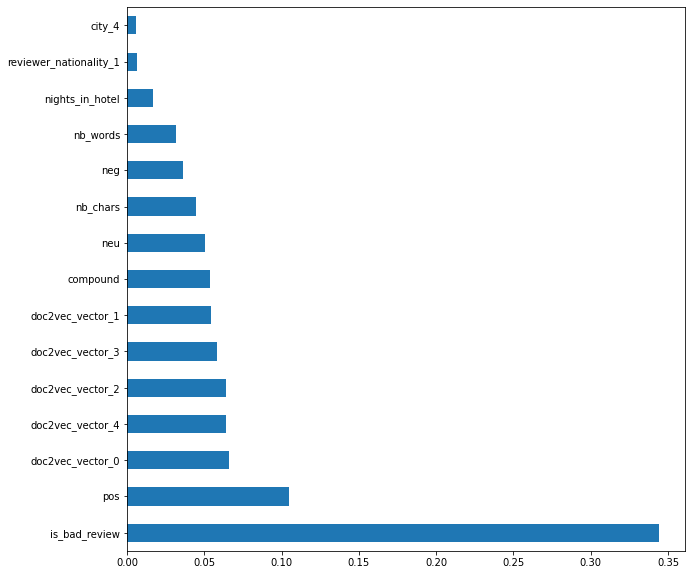

In [122]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [79]:
feat_importances.nlargest(15).index.to_list()
# ['is_bad_review',
#  'pos',
#  'doc2vec_vector_0',
#  'doc2vec_vector_2',
#  'doc2vec_vector_4',
#  'doc2vec_vector_3',
#  'compound',
#  'doc2vec_vector_1',
#  'neu',
#  'nb_chars',
#  'neg',
#  'nb_words',
#  'nights_in_hotel',
#  'reviewer_nationality_1',
#  'city_4']

['is_bad_review',
 'pos',
 'doc2vec_vector_0',
 'doc2vec_vector_2',
 'doc2vec_vector_4',
 'doc2vec_vector_3',
 'compound',
 'doc2vec_vector_1',
 'neu',
 'nb_chars',
 'neg',
 'nb_words',
 'nights_in_hotel',
 'reviewer_nationality_1',
 'city_4']

# Второй прогон  
оставляем толкьо наиболее значимые признаки

In [112]:
important_features = ['is_bad_review',
 'pos',
 'doc2vec_vector_0',
 'doc2vec_vector_2',
 'doc2vec_vector_4',
 'doc2vec_vector_3',
 'compound',
 'doc2vec_vector_1',
 'neu',
 'nb_chars',
 'neg',
 'nb_words',
 'nights_in_hotel',
 'reviewer_nationality_1',
 'city_4',
 'sample',
 'reviewer_score']

In [113]:
data = data[important_features]

In [123]:
test_data.sample(10)

,is_bad_review,pos,doc2vec_vector_0,doc2vec_vector_2,doc2vec_vector_4,doc2vec_vector_3,compound,doc2vec_vector_1,neu,nb_chars,neg,nb_words,nights_in_hotel,reviewer_nationality_1,city_4,reviewer_score
125572,1,0.358,0.066921,0.291734,-0.188893,-0.324354,0.8439,0.200708,0.501,171,0.141,30,4,0,1,0.0
95768,1,0.298,-0.017178,0.514717,0.022294,-0.334614,0.9855,0.143231,0.702,563,0.000,105,8,0,0,0.0
121960,1,0.175,0.063908,0.182523,-0.126459,-0.085603,0.7677,0.386467,0.825,230,0.000,43,7,0,0,0.0
49004,1,0.000,0.074771,-0.090478,-0.143243,-0.089488,-0.5000,0.059547,0.801,76,0.199,17,4,0,1,0.0
50499,1,0.432,0.002838,0.106294,-0.108056,-0.132478,0.5267,0.183106,0.260,51,0.307,9,1,0,1,0.0
22699,1,0.262,0.209593,-0.092433,-0.278265,0.122913,0.9644,0.078803,0.699,368,0.039,78,1,1,1,0.0
74208,1,0.000,0.020019,0.201997,-0.097382,0.001667,0.0000,0.084982,1.000,79,0.000,14,1,1,1,0.0
121104,1,0.225,-0.042212,0.179731,0.009523,-0.188045,-0.3477,0.244337,0.391,51,0.384,9,2,1,1,0.0
45230,1,0.465,-0.059646,-0.025137,0.007952,-0.170801,0.8271,0.197185,0.535,72,0.000,17,1,0,0,0.0
90148,1,0.000,0.008578,0.110399,-0.002470,-0.088327,-0.7096,0.188964,0.459,39,0.541,7,2,1,0,0.0


In [124]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [125]:
test_data.shape

(128935, 15)

In [126]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [127]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


In [128]:
predict_submission

array([3.952, 3.776, 3.403, ..., 4.057, 3.951, 3.876])

In [129]:
len(predict_submission)

128935

In [130]:
list(sample_submission)

['reviewer_score', 'id']

In [131]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,3.952,488440
1,3.776,274649
2,3.403,374688
3,3.559,404352
4,4.023,451596
5,4.064,302161
6,4.131,317079
7,4.313,13963
8,3.925,159785
9,3.792,195089
